In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
#from helper_functions import do_pca, scree_plot, plot_components, pca_results

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

There are four files associated with this project (not including this one):

Udacity_AZDIAS_Subset.csv: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).

Udacity_CUSTOMERS_Subset.csv: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).

Data_Dictionary.md: Detailed information file about the features in the provided datasets.

AZDIAS_Feature_Summary.csv: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the .csv data files in this project: they're semicolon (;) delimited, so you'll need an additional argument in your read_csv() call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.


In [2]:
#mount google drive folder consisting of datasets
from google.colab import drive
drive.mount('/Data')

Mounted at /Data


In [3]:
# check files mounted at drive

!ls "/Data/MyDrive/Colab Notebooks/Udacity_Intro_to_Tensorflow/Project_3_Customer_Segments/Data"


AZDIAS_Feature_Summary.csv  NG	 Udacity_AZDIAS_Subset.csv
Data_Dictionary.md	    old  Udacity_CUSTOMERS_Subset.csv


In [4]:
# Load in the general demographics data.
azdias = pd.read_csv("/Data/MyDrive/Colab Notebooks/Udacity_Intro_to_Tensorflow/Project_3_Customer_Segments/Data/Udacity_AZDIAS_Subset.csv",sep=";")
azdias.head()



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,...,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,...,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,...,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,...,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,...,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,...,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,...,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,...,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,...,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,...,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,-1,3,2,5.0,1,4,2,5,4,4,1,1976,12.0,0,3,2.0,1.0,1.0,1.0,2.0,1.0,1,14,3.0,2,1,3,3,2,1,6,3,4,4,7,5,4,2,3,0.0,...,0.0,4.0,3.0,3.0,4.0,15.0,0.0,8.0,3.0,1992.0,W,3.0,7,7A,41,2.0,1.0,0.0,0.0,0.0,4.0,6.0,3.0,7.0,4.0,3.0,5.0,5.0,5.0,282.0,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,6,1970,1.0,0,-1,2.0,1.0,1.0,1.0,1.0,1.0,0,10,5.0,4,4,7,5,4,7,7,4,4,4,4,4,6,2,-1,0.0,...,0.0,6.0,NaN,6.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,5.0,9,9D,51,0.0,0.0,1.0,1.0,5.0,2.0,7.0,6.0,2.0,3.0,3.0,1.0,2.0,7.0,592.0,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,1,1976,10.0,0,1,0.0,0.0,0.0,0.0,4.0,2.0,1,14,4.0,5,2,5,3,2,3,5,5,7,4,4,5,6,7,2,0.0,...,0.0,5.0,NaN,NaN,5.0,3.0,0.0,8.0,6.0,1992.0,W,7.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,5.0,2.0,6.0,4.0,3.0,2.0,3.0,5.0,688.0,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,1,1994,9.0,0,1,29.0,9.0,9.0,5.0,2.0,1.0,1,14,4.0,7,7,7,5,6,3,2,7,5,2,2,2,7,5,0,0.0,...,0.0,6.0,NaN,1.0,9.0,7.0,0.0,8.0,2.0,1992.0,W,5.0,9,9D,51,0.0,3.0,2.0,0.0,0.0,3.0,2.0,6.0,4.0,4.0,4.0,1.0,3.0,7.0,134.0,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [6]:
# Load in the feature summary file.
feat_info = pd.read_csv("/Data/MyDrive/Colab Notebooks/Udacity_Intro_to_Tensorflow/Project_3_Customer_Segments/AZDIAS_Feature_Summary.csv",sep=";")
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
print(feat_info.attribute)

0                 AGER_TYP
1     ALTERSKATEGORIE_GROB
2                ANREDE_KZ
3            CJT_GESAMTTYP
4        FINANZ_MINIMALIST
              ...         
80                PLZ8_HHZ
81                PLZ8_GBZ
82                  ARBEIT
83             ORTSGR_KLS9
84                RELAT_AB
Name: attribute, Length: 85, dtype: object


Step 1.1: Assess Missing Data
The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the Discussion cell with your findings and decisions at the end of each step that has one!

Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as feat_info) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. [-1,0]), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks

In [8]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [9]:
# Identify missing or unknown data values and convert them to NaNs.

check = azdias.isnull().sum()
print (check)

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64


In [10]:
# sum all the null data before replacing missing values
check.sum()


4896838

In [11]:
# extract the type of missing data in feat_info by removing the "[", "]", and ","
for i in range (len(feat_info)):
  data= (feat_info.iloc[i][3])
  data_replace_1 = data.replace ("[","") # brackets need to be removed 
  data_replace_2 = data_replace_1.replace ("]","") # brackets need to be removed 
  data_split_3 = data_replace_2.split(",") # split the values. inside the list
  missing_list = data_split_3
  
  #convert X,XX, null values to interger
  #replace the missing value with NaN 
  missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_list]
  if missing_or_unknown != ['']:
      azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)


In [12]:
azdias

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,...,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,...,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,...,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,...,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,...,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,NaN,3.0,2,5.0,1,4,2,5,4,4,1,1976.0,12.0,0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,14.0,3.0,2,1,3,3,2,1,6,3,4,4,7,5,4,2,3.0,0.0,...,0.0,4.0,3.0,3.0,4.0,15.0,0.0,8.0,3.0,1992.0,W,3.0,7,7A,41,2.0,1.0,0.0,0.0,NaN,4.0,6.0,3.0,7.0,4.0,3.0,5.0,5.0,5.0,282.0,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,NaN,2.0,1,4.0,3,3,3,2,2,3,6,1970.0,1.0,0,NaN,2.0,1.0,1.0,1.0,1.0,1.0,NaN,10.0,5.0,4,4,7,5,4,7,7,4,4,4,4,4,6,2,NaN,0.0,...,0.0,6.0,NaN,6.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,5.0,9,9D,51,0.0,0.0,1.0,1.0,5.0,2.0,7.0,6.0,2.0,3.0,3.0,1.0,2.0,7.0,592.0,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,NaN,2.0,2,4.0,2,4,2,5,4,3,1,1976.0,10.0,0,1.0,NaN,NaN,NaN,NaN,4.0,2.0,1.0,14.0,4.0,5,2,5,3,2,3,5,5,7,4,4,5,6,7,2.0,0.0,...,0.0,5.0,NaN,NaN,5.0,3.0,0.0,8.0,6.0,1992.0,W,7.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,5.0,2.0,6.0,4.0,3.0,2.0,3.0,5.0,688.0,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,NaN,1.0,1,3.0,1,5,3,5,5,5,1,1994.0,9.0,0,1.0,29.0,9.0,9.0,5.0,2.0,1.0,1.0,14.0,4.0,7,7,7,5,6,3,2,7,5,2,2,2,7,5,0.0,0.0,...,0.0,6.0,NaN,1.0,9.0,7.0,0.0,8.0,2.0,1992.0,W,5.0,9,9D,51,0.0,3.0,2.0,0.0,NaN,3.0,2.0,6.0,4.0,4.0,4.0,1.0,3.0,7.0,134.0,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [13]:
#  check missing count after changing missing or null values to NaN
check_1 = azdias.isnull().sum()
print (check_1)

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64


In [14]:
# check missing values sum after changing missing or null values to NaN
aft_fill = azdias.isnull().sum().sum()
print(aft_fill)

8373929


Step 1.1.2: Assess Missing Data in Each Column
How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's hist() function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the dataset.
# Using the data set above, i check the percentage of null data in each column

percent_null = (azdias.isnull().sum())/len(azdias)*100
print(percent_null)

AGER_TYP                76.955435
ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
                          ...    
PLZ8_HHZ                13.073637
PLZ8_GBZ                13.073637
ARBEIT                  10.926022
ORTSGR_KLS9             10.914689
RELAT_AB                10.926022
Length: 85, dtype: float64


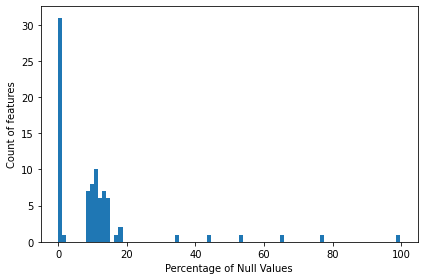

In [16]:
#Plot histogram of missing data there is in each column of the dataset.
n_bins = 85

fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

plt.xlabel('Percentage of Null Values')
plt.ylabel('Count of features')
plt.hist(percent_null,bins=n_bins)


plt.show()

In [17]:
#Investigate patterns in the amount of missing data in each column.
## drop the columns with data more than 20% missing

drop_column = percent_null[percent_null>30]
print(drop_column)

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


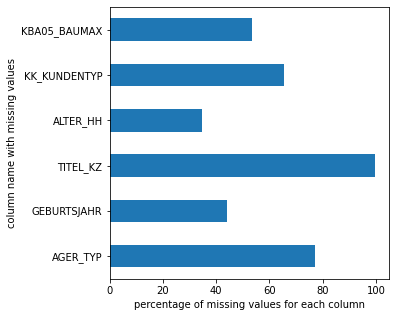

In [18]:
#Show the columns with more than 20% of null data

drop_column.plot.barh(figsize=(5,5))
plt.xlabel('percentage of missing values for each column')
plt.ylabel('column name with missing values')
plt.show()

In [19]:
# Remove the outlier columns from the dataset. 

data_drop = azdias.drop(drop_column.index.tolist(),axis=1)
#print (data_drop)

In [20]:
# check dataset for null/NaN after drop
data_drop.isnull().sum().sum()

5035304

In [21]:
# check null values after drop
percent_null_1 = (data_drop.isnull().sum())/len(data_drop)*100
print(percent_null_1)

ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
                          ...    
PLZ8_HHZ                13.073637
PLZ8_GBZ                13.073637
ARBEIT                  10.926022
ORTSGR_KLS9             10.914689
RELAT_AB                10.926022
Length: 79, dtype: float64


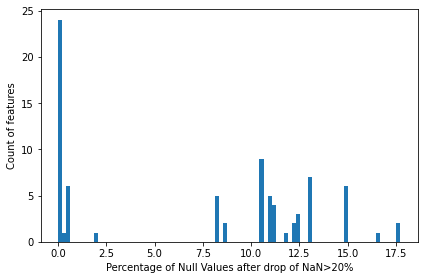

In [22]:
#Plot histogram of missing data after NaN removed.
n_bins = 85

fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

plt.xlabel('Percentage of Null Values after drop of NaN>20%')
plt.ylabel('Count of features')
plt.hist(percent_null_1,bins=n_bins)

plt.show()

#This sum of null count and histogram confirms that NaN removed 

Discussion 1.1.2: Assess Missing Data in Each Column


Most columns have less than 20% missing data. 6 features have been identified to have more than 20% of missing data. After removal these 6 columns, we have a cleaner data set (from 8373929 to 5035304) which can be used future analysis. This sum of null count and histogram confirms that NaN removed 

The columns that were dropped

AGER_TYP        

GEBURTSJAHR     

TITEL_KZ        

ALTER_HH        

KK_KUNDENTYP    

KBA05_BAUMAX    



Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.

You can use seaborn's countplot() function to create a bar chart of code frequencies and matplotlib's subplot() function to put bar charts for the two subplots side by side.
To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.
Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.

In [23]:
# How much data is missing in each row of the dataset?
## using the cleaned data set above, checking missing data in every row

missing_data_by_row =data_drop.isnull().sum(axis=1) # check the missing items in each row

print(missing_data_by_row)

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64


In [24]:
#sum of missing data in all rows
sum_missing_by_row = missing_data_by_row.sum()
print(sum_missing_by_row)

5035304


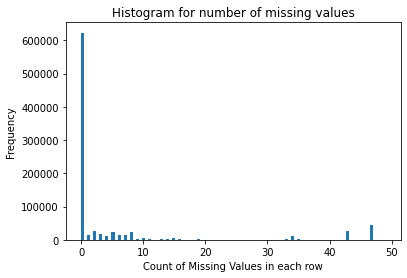

In [25]:
# Plot histrogram showing missing values by row
plt.hist(missing_data_by_row, bins=100)
plt.title('Histogram for number of missing values')
plt.ylabel('Frequency ')
plt.xlabel('Count of Missing Values in each row')
plt.show()


In [26]:

# Write code to divide the data into two subsets based on the number of missing to check data count
# values in each row \\ Split by using 30

data_less_30 = data_drop[missing_data_by_row<30]
data_above_30= data_drop[missing_data_by_row>=30]
# print the set rows with above 30 missing data
print (data_less_30 )

        ALTERSKATEGORIE_GROB  ANREDE_KZ  ...  ORTSGR_KLS9  RELAT_AB
1                        1.0          2  ...          5.0       4.0
2                        3.0          2  ...          5.0       2.0
3                        4.0          2  ...          3.0       3.0
4                        3.0          1  ...          6.0       5.0
5                        1.0          2  ...          3.0       3.0
...                      ...        ...  ...          ...       ...
891216                   3.0          2  ...          NaN       NaN
891217                   2.0          1  ...          6.0       5.0
891218                   2.0          2  ...          2.0       3.0
891219                   1.0          1  ...          7.0       5.0
891220                   4.0          1  ...          4.0       5.0

[798061 rows x 79 columns]


In [27]:
# print the set rows with less 30 missing data to check data count
print (data_above_30 )

        ALTERSKATEGORIE_GROB  ANREDE_KZ  ...  ORTSGR_KLS9  RELAT_AB
0                        2.0          1  ...          NaN       NaN
11                       2.0          1  ...          NaN       NaN
14                       3.0          1  ...          NaN       NaN
17                       2.0          1  ...          NaN       NaN
24                       3.0          2  ...          NaN       NaN
...                      ...        ...  ...          ...       ...
891164                   3.0          2  ...          NaN       NaN
891171                   3.0          2  ...          NaN       NaN
891175                   3.0          2  ...          NaN       NaN
891185                   3.0          1  ...          NaN       NaN
891187                   3.0          2  ...          NaN       NaN

[93160 rows x 79 columns]


In [28]:
# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.
# let the missing percentage be 0
# select type 5 from the dataset 

drop_column_to_list = percent_null[percent_null==0].index
top5 = drop_column_to_list[:5]
print (top5)

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER'],
      dtype='object')


In [29]:
def create_plot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('missing values < 30')
    sns.countplot(azdias.loc[data_less_30.index,column],ax=ax1)

    ax2.set_title('missing values > 30')
    sns.countplot(azdias.loc[data_above_30.index,column],ax=ax2)
    
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


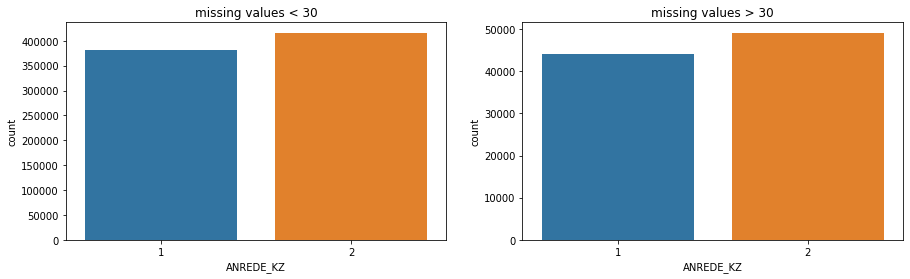

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


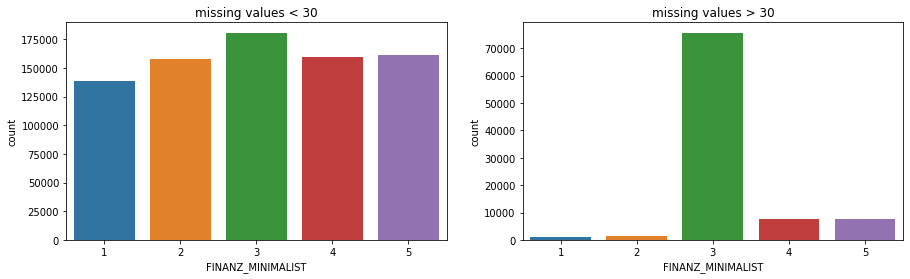

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


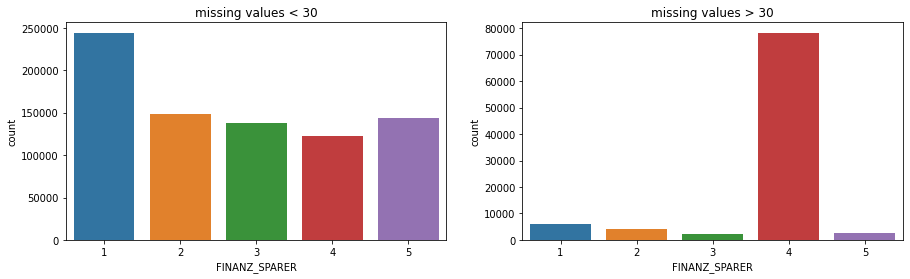

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


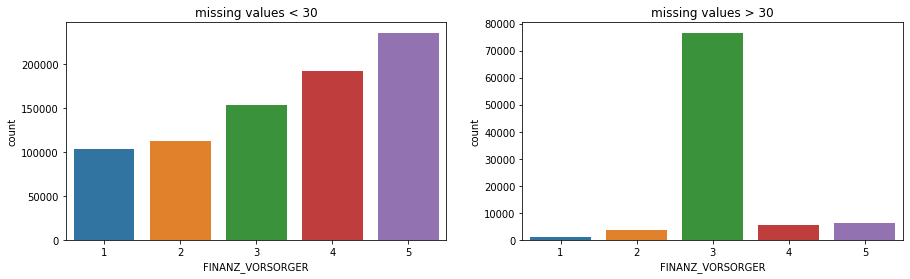

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


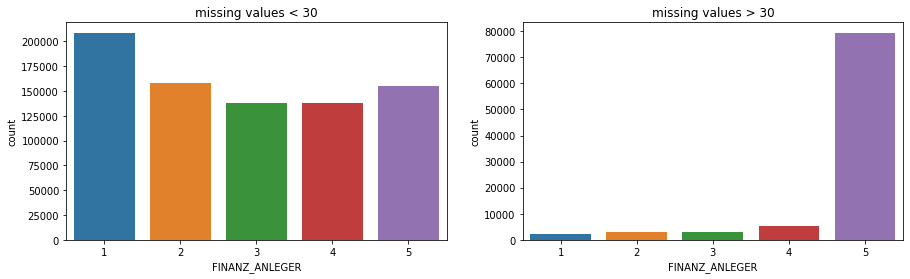

In [30]:
for i in range(top5.size):
    create_plot(top5[i])

##Discussion 1.1.3: Assess Missing Data in Each Row


( Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

For the top 5 datasets, most of the data with lots of missing values are less signficantly (1 order less) with that data with few or missing values.

In [31]:
data_less_30 =data_less_30.fillna(data_less_30.mode().iloc[0])

###Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

Check the third column of the feature summary (feat_info) for a summary of types of measurement.

For numeric and interval data, these features can be kept without changes.

Most of the variables in the dataset are ordinal in nature. 

While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).

Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. 

Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project

In [32]:
# How many features are there of each data type?

feat_info_less_30 =feat_info[feat_info.attribute.isin(data_less_30.columns)]
feat_info_less_30.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

###Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. 

Depending on the number of categories, perform one of the following:

For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.

There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.

For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via OneHotEncoder), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
print(data_less_30.shape)

(798061, 79)


In [34]:
# extract the data with type "categorical"
cat =feat_info_less_30[feat_info_less_30.type=="categorical"]

In [35]:
print (cat)

           attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
41          VERS_TYP            person  categorical               [-1]
42    

In [36]:
# shape of dataset with categorical type
print(cat.shape)

(18, 4)


In [37]:
# assign categorical features to binary or multi list

binary=[]
multi=[]

for i in cat.attribute:
    if (len(data_less_30[i].unique())==2):
        binary.append(i)
    else:
        multi.append(i)

print (binary)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [38]:
# check the items with cateogrical binary data
for i in binary:
    print(data_less_30[i].value_counts())

2    416177
1    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    430959
1.0    367102
Name: VERS_TYP, dtype: int64
W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64


In [39]:
# check the items with cateogrical multi data
print (multi)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']




Customer set
multi ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [40]:
for j in multi:
    print(data_less_30[j].value_counts())

4.0    203040
3.0    147220
2.0    141269
5.0    111114
6.0    102107
1.0     93311
Name: CJT_GESAMTTYP, dtype: int64
6    289061
1    197171
5    106332
2    104773
4     55922
3     44802
Name: FINANZTYP, dtype: int64
12.0    135006
10.0    102831
8.0      83030
11.0     75103
5.0      70501
4.0      60422
9.0      57131
3.0      53101
1.0      50659
2.0      43857
7.0      40681
6.0      25739
Name: GFK_URLAUBERTYP, dtype: int64
1.0     434024
10.0    128974
2.0      98555
11.0     48746
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    434024
5.0    188172
2.0     98555
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
1.0     211598
9.0     136353
10.0    111574
2.0     111118
4.0      73973
3.0      68918
6.0      28896
5.0      27592
8.0      18835
7.0       9204
Name: LP_STATUS_FEIN, dtype: int64
1.0    322716
2.0    170483
4.0    155188
5.0    111574
3.0     38100
Na

In [41]:
# Re-encode categorical variable(s) to be kept in the analysis.
re_code_values = {'W': 0, 'O': 1}
data_replace_cat = data_less_30.replace({'OST_WEST_KZ':re_code_values})

In [42]:
#check shape
print(data_replace_cat.shape)

(798061, 79)


In [43]:
multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [44]:
for j in multi:
    #print(data_less_30[j].
    print(j)

CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
ZABEOTYP
GEBAEUDETYP
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [45]:
#for f in multi:
data_drop_multi=data_replace_cat.drop (multi, axis=1)


In [46]:
print(data_drop_multi.shape)

(798061, 66)


In [47]:
#print(data_replace_cat.shape)

In [48]:
#test11 = data_replace_cat.drop ('LP_FAMILIE_FEIN', axis=1)

In [49]:
# replace multi category with dummies
#data_drop_multi = pd.get_dummies(data=data_replace_cat,columns=multi)

In [50]:
# check shape of dataset after adding dummies 
## Dummies introduced 100 new columns
#print(data_drop_multi.shape)

In [51]:
data_drop_multi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 66 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   798061 non-null  float64
 1   ANREDE_KZ              798061 non-null  int64  
 2   FINANZ_MINIMALIST      798061 non-null  int64  
 3   FINANZ_SPARER          798061 non-null  int64  
 4   FINANZ_VORSORGER       798061 non-null  int64  
 5   FINANZ_ANLEGER         798061 non-null  int64  
 6   FINANZ_UNAUFFAELLIGER  798061 non-null  int64  
 7   FINANZ_HAUSBAUER       798061 non-null  int64  
 8   GREEN_AVANTGARDE       798061 non-null  int64  
 9   HEALTH_TYP             798061 non-null  float64
 10  LP_LEBENSPHASE_FEIN    798061 non-null  float64
 11  LP_LEBENSPHASE_GROB    798061 non-null  float64
 12  PRAEGENDE_JUGENDJAHRE  798061 non-null  float64
 13  RETOURTYP_BK_S         798061 non-null  float64
 14  SEMIO_SOZ              798061 non-nu

#### Discussion 1.2.1: Re-Encode Categorical Features

( Which ones did you keep, which did you drop, and what engineering steps did you perform?)

1. Re-encoded the non-binary values in 'OST_WEST_KZ' as numbers (0,1).
2. Kept all binary features
3. Used pandas to encode multi-level variable to dummy


### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. 

There are two in particular that deserve attention; the handling of the rest are up to your own choices:

"PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: 

generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). 

While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.


"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. 

Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check Data_Dictionary.md for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [52]:

# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

data_drop_multi.PRAEGENDE_JUGENDJAHRE.head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [53]:
#creating more levels with decade and movement
decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [54]:
#replace the column with 2 new columns "DECADE" and "MOVEMENT"
data_drop_multi["DECADE"]=data_drop_multi.PRAEGENDE_JUGENDJAHRE
data_drop_multi["MOVEMENT"]=data_drop_multi.PRAEGENDE_JUGENDJAHRE

In [55]:
# fill new columns with dictionaries
data_drop_multi["DECADE"].replace(decade,inplace=True)
data_drop_multi["MOVEMENT"].replace(movement,inplace=True)

#remove orginal column
data_drop_multi.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)

In [56]:
# check the filled columns 
data_drop_multi["DECADE"].head()

1    6.0
2    6.0
3    4.0
4    4.0
5    2.0
Name: DECADE, dtype: float64

In [57]:
data_drop_multi["MOVEMENT"].head()

1    1.0
2    0.0
3    1.0
4    1.0
5    1.0
Name: MOVEMENT, dtype: float64

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [58]:

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#Wealth and Life Stage dict
wealth={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }
life={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5
}

In [59]:
#create two features
data_drop_multi["WEALTH"]=data_drop_multi.CAMEO_INTL_2015
data_drop_multi["LIFE_STAGE"]=data_drop_multi.CAMEO_INTL_2015
#replace with new variables
data_drop_multi["WEALTH"].replace(wealth,inplace=True)
data_drop_multi["LIFE_STAGE"].replace(life,inplace=True)

#drop the CAMEO_INTL_2015 column
data_drop_multi.drop("CAMEO_INTL_2015",axis=1,inplace=True)

In [60]:
data_drop_multi["WEALTH"].head()

1    5
2    2
3    1
4    4
5    5
Name: WEALTH, dtype: int64

In [61]:
data_drop_multi["LIFE_STAGE"].head()

1    1
2    4
3    2
4    3
5    4
Name: LIFE_STAGE, dtype: int64

In [62]:
print(data_drop_multi.shape)

(798061, 68)


In [63]:
#drop the the old column
#data_drop_multi.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)

#data_drop_multi.drop("CAMEO_INTL_2015",axis=1,inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

2 feature columns
1. PRAEGENDE_JUGENDJAHRE
2. CAMEO_INTL_2015


Created two new featurea for each column

Create two dictionaries for PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015

Replace the 2 features with the dictionaries as new feature columns ie. drop the old features


###Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:

--All numeric, interval, and ordinal type columns from the original dataset.

--Binary categorical features (all numerically-encoded).

--Engineered features from other multi-level categorical features and mixed features.

--Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. 

Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. 

As a reminder, your data should only be from the subset with few or no missing values.

In [64]:
feat_info.type.unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

In [65]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

## removed the mixed type

mixed_variables=feat_info_less_30[feat_info.type=="mixed"]
print(mixed_variables)

                attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]
79            PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [66]:
if i in mixed_variables.attribute:
  data_drop_multi.drop(i, axis=1, inplace=True)
else:
  data_drop_multi

In [67]:
data_drop_multi.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2,4
3,4.0,2,4,2,5,2,1,2,0,2.0,1.0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,6.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1,2
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4,3
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5,4


In [68]:
print(data_drop_multi.shape)

(798061, 68)


###Step 1.3: Create a Cleaning Function
Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [69]:
def clean_data_2(azdias,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...



    for i in range (len(feat_info)):
      data= (feat_info.iloc[i][3])
      data_replace_1 = data.replace ("[","") # brackets need to be removed 
      data_replace_2 = data_replace_1.replace ("]","") # brackets need to be removed 
      data_split_3 = data_replace_2.split(",") # split the values. inside the list
      missing_list = (data_split_3)
      missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_list]
      if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
      #print ("missin",missing_or_unknown)
      aft_fill = azdias.isnull().sum().sum()
      #print("fill",aft_fill)
     
      # remove selected columns and rows, ...
      for col in azdias.columns:
        azdias = azdias.replace({col: ['XX', 'X']}, np.nan)
     
      #drop columns 
      #drop_column=['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP','TITEL_KZ']
      percent_null = (azdias.isnull().sum())/len(azdias)*100
      drop_column = percent_null[percent_null>30]
      data_drop = azdias.drop(drop_column.index.tolist(),axis=1)
      #print("drop_col",drop_column)
   
     #drop rows
      missing_data_by_row =data_drop.isnull().sum(axis=1) # check the missing items in each row
      data_less_30 = data_drop[missing_data_by_row<=30]
      data_above_30= data_drop[missing_data_by_row>=30]
      data_less_30 =data_less_30.fillna(data_less_30.mode().iloc[0])
      #drop_column_to_list = percent_null[percent_null==0].index
      #top5 = drop_column_to_list[:5]
     # print ("drop_row",top5)

      sum_missing_by_row = missing_data_by_row.sum()
      #print("mssing row",sum_missing_by_row)
      #print("data_above_30",data_above_30)

      # select, re-encode, and engineer column values.
      feat_info_less_30 =feat_info[feat_info.attribute.isin(data_less_30.columns)]
      cat =feat_info_less_30[feat_info_less_30.type=="categorical"]
      
      binary=[]
      multi=[]

      for i in cat.attribute:
        if (len(data_less_30[i].unique())==2):
          binary.append(i)
        else:
          multi.append(i) 
      
      #print ("multi", multi)

      re_code_values = {'W': 0, 'O': 1}
      data_replace_cat = data_less_30.replace({'OST_WEST_KZ':re_code_values})
      #print ("before dummy", data_replace_cat.shape)
      
      # replace multi category with dummies
      #data_drop_multi = pd.get_dummies(data=data_replace_cat,columns=multi)
      
      #for j in multi:

      data_drop_multi = data_replace_cat.drop(multi, axis=1)

      #print ("dummy",data_drop_multi.shape)
      
      #Engineer the data

      decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
      movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

      data_drop_multi["DECADE"]=data_drop_multi.PRAEGENDE_JUGENDJAHRE
      data_drop_multi["MOVEMENT"]=data_drop_multi.PRAEGENDE_JUGENDJAHRE
      data_drop_multi["DECADE"].replace(decade,inplace=True)
      data_drop_multi["MOVEMENT"].replace(movement,inplace=True)
      data_drop_multi.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
      #print ("after PRAEGENDE_JUGENDJAHRE clean", data_drop_multi.shape)
      
      
      wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,'31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,'51':5, '52':5, '53':5, '54':5, '55':5}
      life = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,'31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,'51':1, '52':2, '53':3, '54':4, '55':5}


      #replace with new variables
      data_drop_multi["WEALTH"]=data_drop_multi.CAMEO_INTL_2015
      data_drop_multi["LIFE_STAGE"]=data_drop_multi.CAMEO_INTL_2015
      data_drop_multi["WEALTH"].replace(wealth,inplace=True)
      data_drop_multi["LIFE_STAGE"].replace(life,inplace=True)
      data_drop_multi.drop("CAMEO_INTL_2015",axis=1,inplace=True)
      #print ("after CAMEO_INTL_2015 clean", data_drop_multi.shape)
      
      # remove mixed type variable
      if i in mixed_variables.attribute:
        data_drop_multi.drop(i, axis=1, inplace=True)
      else:
        data_drop_multi

      # Return the cleaned dataframe.
      return data_drop_multi

In [70]:
azdias_test = azdias = pd.read_csv("/Data/MyDrive/Colab Notebooks/Udacity_Intro_to_Tensorflow/Project_3_Customer_Segments/Data/Udacity_AZDIAS_Subset.csv",sep=";")


In [71]:
feat_info_test = pd.read_csv("/Data/MyDrive/Colab Notebooks/Udacity_Intro_to_Tensorflow/Project_3_Customer_Segments/Data/AZDIAS_Feature_Summary.csv",sep=";")

In [72]:
test=clean_data_2(azdias_test, feat_info_test)

In [73]:

test.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1,2,1,5,2,5,4,5,1996,0,3,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,0.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6,1,5,1
2,3,2,1,4,1,2,3,5,1979,1,3,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6,0,2,4
3,4,2,4,2,5,2,1,2,1957,0,2,0.0,0.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,13.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,0,7.0,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4,1,1,2
4,3,1,4,3,4,1,3,2,1963,0,3,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4,1,4,3
5,1,2,3,1,5,2,2,5,1943,0,3,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,10.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2,1,5,4


In [74]:
test

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1,2,1,5,2,5,4,5,1996,0,3,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,0.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6,1,5,1
2,3,2,1,4,1,2,3,5,1979,1,3,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6,0,2,4
3,4,2,4,2,5,2,1,2,1957,0,2,0.0,0.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,13.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,0,7.0,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4,1,1,2
4,3,1,4,3,4,1,3,2,1963,0,3,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4,1,4,3
5,1,2,3,1,5,2,2,5,1943,0,3,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,10.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3,2,1,4,2,5,4,4,1976,0,3,2.0,1.0,3.0,2,1,3,3,2,1,6,3,4,4,7,5,4,2,0.0,17.0,1.0,0.0,4.0,3.0,4.0,15.0,0.0,3.0,1992.0,0,3.0,2.0,1.0,0.0,0.0,0.0,4.0,6.0,3.0,7.0,4.0,3.0,5.0,5.0,5.0,282.0,3.0,2.0,0.0,0.0,1.0,2.0,3.0,4.0,5.0,3.0,6,1,4,1
891217,2,1,3,3,3,2,2,3,1970,0,-1,2.0,1.0,5.0,4,4,7,5,4,7,7,4,4,4,4,4,6,2,0.0,16.0,1.0,0.0,6.0,6.0,9.0,11.0,0.0,1.0,1992.0,0,5.0,0.0,0.0,1.0,1.0,5.0,2.0,7.0,6.0,2.0,3.0,3.0,1.0,2.0,7.0,592.0,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0,5,1,5,1
891218,2,2,2,4,2,5,4,3,1976,0,1,0.0,0.0,4.0,5,2,5,3,2,3,5,5,7,4,4,5,6,7,0.0,17.0,0.0,0.0,5.0,6.0,5.0,3.0,0.0,6.0,1992.0,0,7.0,1.0,3.0,1.0,0.0,0.0,3.0,5.0,2.0,6.0,4.0,3.0,2.0,3.0,5.0,688.0,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0,6,1,2,4
891219,1,1,1,5,3,5,5,5,1994,0,1,29.0,9.0,4.0,7,7,7,5,6,3,2,7,5,2,2,2,7,5,0.0,0.0,1.0,0.0,6.0,1.0,9.0,7.0,0.0,2.0,1992.0,0,5.0,0.0,3.0,2.0,0.0,0.0,3.0,2.0,6.0,4.0,4.0,4.0,1.0,3.0,7.0,134.0,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0,6,1,5,1


Step 2: Feature Transformation
--

Step 2.1: Apply Feature Scaling
Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

Starting from this part of the project, you'll want to keep an eye on the API reference page for sklearn to help you navigate to all of the classes and functions that you'll need. 

In this substep, you'll need to check the following:

sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. 

This can be as simple as just removing all data points with missing data, or applying an Imputer to replace all missing values. 

You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. 

Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.

For the actual scaling function, a StandardScaler instance is suggested, scaling each feature to mean 0 and standard deviation 1.

For these classes, you can make use of the .fit_transform() method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [75]:

test.isnull().sum().sum()

0

In [76]:
test.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1,2,1,5,2,5,4,5,1996,0,3,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,0.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6,1,5,1
2,3,2,1,4,1,2,3,5,1979,1,3,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6,0,2,4
3,4,2,4,2,5,2,1,2,1957,0,2,0.0,0.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,13.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,0,7.0,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4,1,1,2
4,3,1,4,3,4,1,3,2,1963,0,3,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4,1,4,3
5,1,2,3,1,5,2,2,5,1943,0,3,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,10.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2,1,5,4


In [77]:
data_drop_multi.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2,4
3,4.0,2,4,2,5,2,1,2,0,2.0,1.0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,6.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1,2
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4,3
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5,4


In [78]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


from sklearn.impute import SimpleImputer
imputer0 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

#creare a dataframe after fit transform
adi_imputed = pd.DataFrame(imputer0.fit_transform(test))
#pd.DataFrame(fill_missing.fit_transform(azdias_clean))

In [79]:
print(adi_imputed.shape)

(798073, 70)


In [80]:
# check after imputed 
adi_imputed.isnull().sum().sum()

0

In [81]:
adi_imputed.columns = test.columns
adi_imputed.index = test.index

In [82]:
adi_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,1996.0,0.0,3.0,21.0,6.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,0.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,4.0,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1979.0,1.0,3.0,3.0,1.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0.0,2.0,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,1957.0,0.0,2.0,0.0,0.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,13.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,0.0,7.0,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,1963.0,0.0,3.0,32.0,10.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0.0,3.0,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,1943.0,0.0,3.0,8.0,2.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,10.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0.0,7.0,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [83]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler() 
adi_imputed_clean_scaled= scaler1.fit_transform(adi_imputed)

In [84]:
fit1 = scaler1.fit(adi_imputed)

In [85]:
adi_imputed_clean_scaled.shape

(798073, 70)

In [86]:
X = pd.DataFrame(adi_imputed_clean_scaled, columns=list(adi_imputed))
print (X)

        ALTERSKATEGORIE_GROB  ANREDE_KZ  ...    WEALTH  LIFE_STAGE
0                  -1.681275   0.957905  ...  1.175653   -1.248884
1                   0.169121   0.957905  ... -0.869681    0.767100
2                   1.094318   0.957905  ... -1.551459   -0.576889
3                   0.169121  -1.043944  ...  0.493875    0.095105
4                  -1.681275   0.957905  ...  1.175653    0.767100
...                      ...        ...  ...       ...         ...
798068              0.169121   0.957905  ...  0.493875   -1.248884
798069             -0.756077  -1.043944  ...  1.175653   -1.248884
798070             -0.756077   0.957905  ... -0.869681    0.767100
798071             -1.681275  -1.043944  ...  1.175653   -1.248884
798072              1.094318  -1.043944  ...  0.493875    0.095105

[798073 rows x 70 columns]


Discussion 2.1: Apply Feature Scaling
--
(reporting your decisions regarding feature scaling.)

Replaced missing values with imputer. Used StandardScaler to scale the features using mean and standard deviation.


Step 2.2: Perform Dimensionality Reduction
--
On your scaled data, you are now ready to apply dimensionality reduction techniques.

Use sklearn's PCA class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. 

To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).

Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's plot() function. 

Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.

Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation

In [87]:
run_pca = PCA()

In [88]:

run_pca.fit(X)

PCA()

In [89]:
x=(np.arange(len(run_pca.explained_variance_ratio_)))

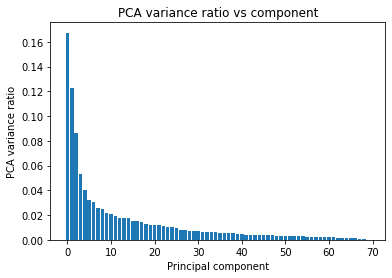

In [90]:
plt.bar(x, run_pca.explained_variance_ratio_)
plt.title("PCA variance ratio vs component")
plt.xlabel("Principal component")
plt.ylabel("PCA variance ratio")
plt.show()

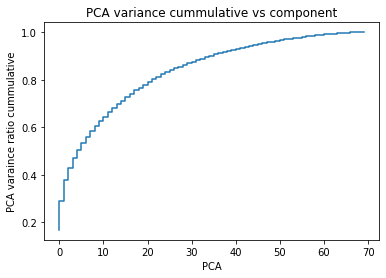

In [91]:
#Plot histogram of missing data after PCA.


y = run_pca.explained_variance_ratio_.cumsum()

plt.title("PCA variance cummulative vs component")
plt.xlabel('PCA')
plt.ylabel('PCA varaince ratio cummulative')


#step = cumm.hist(x, n_bins, density=True,cumulative=True, label='Empirical')

plt.step(x, y, label='pre (default)')

#plt.show()

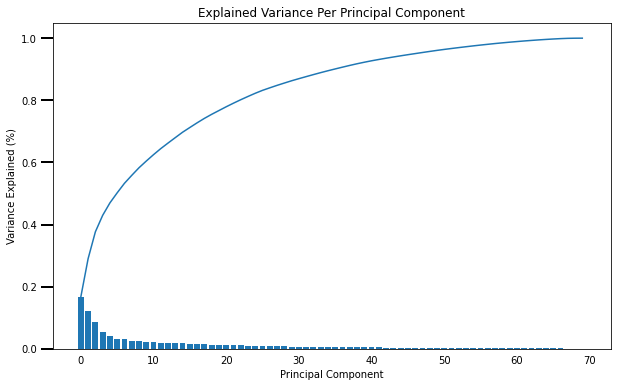

In [92]:



def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
        #ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(run_pca)

Discussion 2.2: Perform Dimensionality Reduction
--

How many principal components / transformed features are you retaining for the next step of the analysis?

Retain 25 components,80% of the variance ratio cutting the features down by more than 50% for next phase of analysis.

In [93]:

pca_25 = PCA(n_components=25)
fit_25 = pca_25.fit_transform(X)

In [94]:
fit_25

array([[ 3.20023131, -3.03080605, -2.94985841, ...,  1.6116722 ,
        -0.37145614,  1.02823909],
       [-0.79857886,  0.45862607, -3.08912263, ...,  0.18382399,
        -0.95599621, -0.71686289],
       [-3.60146669,  1.90195558, -0.57568435, ...,  0.28532471,
         0.46181223,  2.371329  ],
       ...,
       [-1.35976603, -3.09102863, -2.98541491, ..., -0.83494288,
        -1.20773754,  0.08568536],
       [ 5.07106418, -4.2395044 ,  2.15972809, ..., -0.36577172,
        -0.54380467,  1.04510712],
       [-0.33373331,  1.25898392,  3.12603299, ...,  0.91721074,
         0.29789193, -0.84453259]])

In [95]:
x1=(np.arange(len(pca_25.explained_variance_ratio_)))

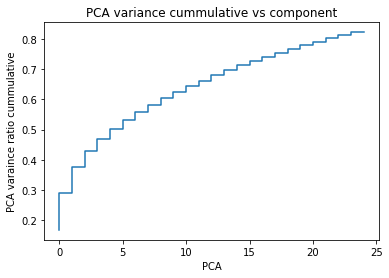

In [96]:
#Plot histogram of variance ratio data after PCA.


y1 = pca_25.explained_variance_ratio_.cumsum()

plt.title("PCA variance cummulative vs component")
plt.xlabel('PCA')
plt.ylabel('PCA varaince ratio cummulative')


#step = cumm.hist(x, n_bins, density=True,cumulative=True, label='Empirical')

plt.step(x1, y1, label='pre (default)')

#plt.show()

In [97]:
#scree_plot(pca_25)

Step 2.3: Interpret Principal Components¶
--

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). 

The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. 

If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. 

To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. 

Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.

You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the i-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [98]:
ratios = np.sort(run_pca.explained_variance_ratio_)

In [99]:
# shape of PCA resutls
print((run_pca.components_).shape)

(70, 70)


In [100]:
# create a function for finding weights

def find_weight (pca,i):
  frame = pd.DataFrame(pca.components_, columns=list(adi_imputed.columns))
  weights = frame.iloc[i]
  sorted_weights = weights.sort_values(ascending=False)
  return sorted_weights

  


In [101]:
#1st PCA
pca_weight_0 = find_weight(pca_25, 0)
print (pca_weight_0)

PLZ8_ANTG3           0.226105
PLZ8_ANTG4           0.220206
PLZ8_BAUMAX          0.217327
WEALTH               0.200996
ORTSGR_KLS9          0.200443
                       ...   
FINANZ_MINIMALIST   -0.193881
KBA05_ANTG1         -0.208391
KBA05_GBZ           -0.215157
MOBI_REGIO          -0.220496
PLZ8_ANTG1          -0.226098
Name: 0, Length: 70, dtype: float64


In [102]:
# 2nd PCA
pca_weight_1 = find_weight(pca_25, 1)
print (pca_weight_1)

ALTERSKATEGORIE_GROB    0.263067
FINANZ_VORSORGER        0.247909
SEMIO_ERL               0.242995
SEMIO_LUST              0.194624
RETOURTYP_BK_S          0.166563
                          ...   
SEMIO_PFLICHT          -0.241390
SEMIO_TRADV            -0.244729
DECADE                 -0.247459
FINANZ_SPARER          -0.254295
SEMIO_REL              -0.266649
Name: 1, Length: 70, dtype: float64


In [103]:
# 3rd PCA
pca_weight_2 = find_weight(pca_25, 2)
print (pca_weight_2)

SEMIO_VERT           0.346032
SEMIO_SOZ            0.259506
SEMIO_FAM            0.245460
SEMIO_KULT           0.230813
FINANZ_MINIMALIST    0.165727
                       ...   
SEMIO_RAT           -0.223252
SEMIO_KRIT          -0.274949
SEMIO_DOM           -0.314194
SEMIO_KAEM          -0.337868
ANREDE_KZ           -0.368605
Name: 2, Length: 70, dtype: float64


Discussion 2.3: Interpret Principal Components
--

Reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?


High principal component score indicate high correlation. Negative results are part of correlation process are show poor correlation

1st PCA
---

a. Own 6-10+ houses -- PLZ8_ANTG3, PLZ8_ANTG4 (+ correlated)

b. Most common buildings in PLZ8 region -- PLZ8_BAUMAX (+ correlated)

c. Wealthy -- WEALTH (+correlated)

d. Low financial interest -- FINANZ_MINIMALIST (- correlated)


2nd PCA
---
a. Older in age or age uniformly distributed -- ALTERSKATEGORIE_GROB (+ correlated)

b. Financial prepared -- FINANZ_VORSORGER ( + correlated)

c. Determined Minimal-Returner -- RETOURTYP_BK_S (+ correlated)

d. Low money saver -- FINANZ_SPARER   (-correlated)

3rd PCA
---
a. High -  financial interest FINANZ_MINIMALIST (+correlated)

b.  Family minded -- SEMIO FAM (+correlated)

c.  Socially minded -- SEMIO SOZ (+correlated) 

c. High financial interest -- FINANZ_MINIMALIST (+correlated)






### Step 3: Clustering

Step 3.1: Apply Clustering to General Population
You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

Use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.

Then, compute the average difference from each point to its assigned cluster's center. Hint: The KMeans object's .score() method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.

Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. 

Use this fact to select a final number of clusters in which to group the data. Warning: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. 

You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [104]:
from sklearn.cluster import KMeans


In [105]:
#num_clusters=np.arange(1,3)


In [106]:

def k_mean_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [107]:
scores = []
range_k = list(range(1,15))
for k in range_k:
    scores.append(k_mean_score(fit_25, k))

Text(0, 0.5, 'SSE')

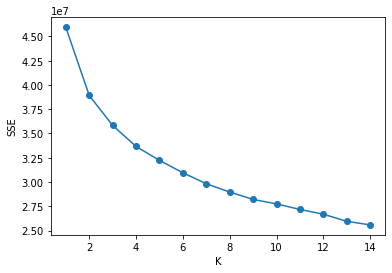

In [108]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range_k, scores, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')

In [109]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = KMeans(n_clusters = 4)
model = k.fit(fit_25)
azdias_pred = model.predict(fit_25)

In [110]:
print(azdias_pred)

[3 2 2 ... 0 3 1]


Discussion 3.1: Apply Clustering to General Population
--

Into how many clusters have you decided to segment the population?

Based on Kmeans elbow,  I am using 4 clusters to segment the population

Step 3.2: Apply All Steps to the Customer Data
Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

Don't forget when loading in the customers data, that it is semicolon (;) delimited.
Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the clean_data() function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a .fit() or .fit_transform() method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [111]:
# Load in the general demographics -- Customers data.
customer_set_1 = pd.read_csv("/Data/MyDrive/Colab Notebooks/Udacity_Intro_to_Tensorflow/Project_3_Customer_Segments/Data/Udacity_CUSTOMERS_Subset.csv",sep=";")
customer_set_1.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,...,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,...,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,...,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,...,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,...,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,...,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [112]:
    check = customer_set_1.isnull().sum()
    print ("check",check)

check AGER_TYP                    0
ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
CJT_GESAMTTYP            3213
FINANZ_MINIMALIST           0
                        ...  
PLZ8_HHZ                52764
PLZ8_GBZ                52764
ARBEIT                  50476
ORTSGR_KLS9             50476
RELAT_AB                50476
Length: 85, dtype: int64


In [113]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



In [114]:
print(customer_set_1.shape)

(191652, 85)


In [115]:
# Load in the general demographics -- Customers data.
feat_set = pd.read_csv("/Data/MyDrive/Colab Notebooks/Udacity_Intro_to_Tensorflow/Project_3_Customer_Segments/Data/AZDIAS_Feature_Summary.csv",sep=";")
feat_set.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]



Note : After running the customer dataset, i admend original cleaning function

Using customer dataset, CAMEO_INTL_2015  will be removed if we filter >20. Change to null filter >30 null values

CAMEO_INTL_2015        26.312274


In [116]:
# Load in the general demographics -- Customers data.
customer_set_2 = pd.read_csv("/Data/MyDrive/Colab Notebooks/Udacity_Intro_to_Tensorflow/Project_3_Customer_Segments/Data/Udacity_CUSTOMERS_Subset.csv",sep=";")

In [117]:
# clean customer data-set using clean function

customer_clean_set_2 =clean_data_2(customer_set_1,feat_info_test)

In [118]:
customer_clean_set_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4,1,5,1,5,1,2,2,0,1,1,20.0,5.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,10.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0,7.0,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,2,0,1,3
2,4,2,5,1,5,1,4,4,0,1,2,13.0,3.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,6.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,0,2.0,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,2,0,3,4
3,4,1,5,1,5,2,1,2,0,0,2,0.0,0.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,8.0,0.0,0.0,4.0,6.0,9.0,0.0,0.0,2.0,1992.0,0,7.0,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,1,1,2,4
4,3,1,3,1,4,4,5,2,1960,0,3,31.0,10.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0.0,20.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,0,3.0,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,4,1,4,1
5,3,1,5,1,5,1,2,3,0,1,3,17.0,5.0,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,0.0,11.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,0,1.0,2.0,2.0,1.0,0.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0,2,0,3,4


In [119]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

customer_clean_set_2.dtypes

ALTERSKATEGORIE_GROB      int64
ANREDE_KZ                 int64
FINANZ_MINIMALIST         int64
FINANZ_SPARER             int64
FINANZ_VORSORGER          int64
                         ...   
RELAT_AB                float64
DECADE                    int64
MOVEMENT                  int64
WEALTH                    int64
LIFE_STAGE                int64
Length: 70, dtype: object

In [120]:
# replace NaN

#from sklearn.impute import SimpleImputer
#imputer1 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
customer_clean_imputed = pd.DataFrame(imputer0.transform(customer_clean_set_2))


In [121]:
customer_clean_imputed.isnull().sum().sum()


0

In [122]:
customer_clean_set_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4,1,5,1,5,1,2,2,0,1,1,20.0,5.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,10.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0,7.0,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,2,0,1,3
2,4,2,5,1,5,1,4,4,0,1,2,13.0,3.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,6.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,0,2.0,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,2,0,3,4
3,4,1,5,1,5,2,1,2,0,0,2,0.0,0.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,8.0,0.0,0.0,4.0,6.0,9.0,0.0,0.0,2.0,1992.0,0,7.0,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,1,1,2,4
4,3,1,3,1,4,4,5,2,1960,0,3,31.0,10.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0.0,20.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,0,3.0,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,4,1,4,1
5,3,1,5,1,5,1,2,3,0,1,3,17.0,5.0,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,0.0,11.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,0,1.0,2.0,2.0,1.0,0.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0,2,0,3,4


In [124]:
#imputer2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

customer_clean_imputed = pd.DataFrame(imputer0.transform(customer_clean_set_2))

In [125]:
# Apply Standard Scaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
customer_clean_imputed_scaled = scaler1.transform(customer_clean_imputed)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [126]:
customer_clean_imputed_scaled

array([[ 1.09431825, -1.04394444,  1.40906485, ..., -1.70655604,
        -1.55145936,  0.09510547],
       [ 1.09431825,  0.95790538,  1.40906485, ..., -1.70655604,
        -0.18790323,  0.76709997],
       [ 1.09431825, -1.04394444,  1.40906485, ...,  0.58597548,
        -0.8696813 ,  0.76709997],
       ...,
       [ 1.09431825, -1.04394444,  1.40906485, ..., -1.70655604,
        -0.8696813 ,  0.76709997],
       [ 0.16912063,  0.95790538, -0.76867716, ...,  0.58597548,
        -0.8696813 ,  0.76709997],
       [-0.756077  , -1.04394444,  1.40906485, ...,  0.58597548,
        -0.18790323,  0.09510547]])

In [127]:
#customer_pca = pca_25.fit_transform(customer_clean_imputed_scaled)
customer_pca = pca_25.transform(customer_clean_imputed_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


In [128]:
customer_pca

array([[-5.49812695,  1.62021865,  4.33418531, ...,  0.09017306,
         0.00798521, -0.22721916],
       [-0.43272686,  5.18343435, -0.54893138, ...,  0.25697497,
        -0.50839404, -0.36848731],
       [-3.76659054,  1.06810161,  2.85958864, ...,  0.17716914,
         0.62723862,  0.16928969],
       ...,
       [-4.29852334,  3.09663058,  2.517269  , ..., -0.39009573,
        -0.26962067,  0.35201586],
       [-1.13107943,  2.84544853, -1.89567645, ...,  0.59469117,
        -0.28893422,  0.34200365],
       [-4.51427349, -2.22729443,  2.37546059, ...,  0.14461239,
         0.50047569,  0.04831881]])

In [129]:
# Predict using Kmeans model
customers_predict = model.predict(customer_pca)


In [130]:
print(customers_predict)

[2 1 2 ... 2 2 2]


In [131]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def compare_dist (general,customers):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('General')
    sns.countplot(general,ax=ax1)

    ax2.set_title('Customers')
    sns.countplot(customers,ax=ax2)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


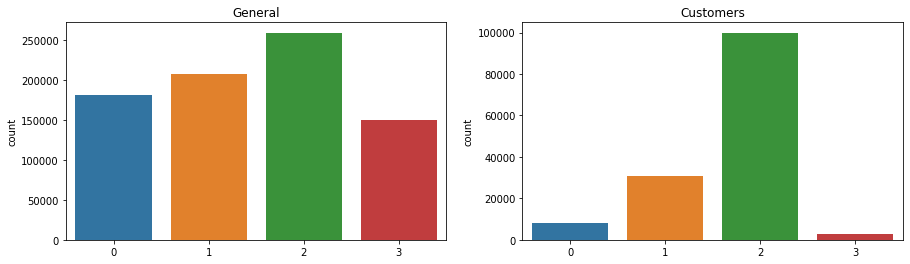

In [132]:
compare_dist(azdias_pred,customers_predict)

Cluster 0  is under-represented in customer group as compared to general

Cluster 1 is over-represented in customer group as compared to general

In [141]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_under = pd.DataFrame(scaler1.inverse_transform(pca_25.inverse_transform(customer_pca[np.where(customers_predict==3)])).round(), columns=list(customer_clean_set_2.columns))

In [142]:
cluster_under.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1.0,2.0,4.0,2.0,3.0,4.0,4.0,1319.0,0.0,1.0,6.0,2.0,3.0,7.0,7.0,7.0,5.0,6.0,4.0,2.0,7.0,4.0,3.0,2.0,3.0,6.0,5.0,0.0,13.0,1.0,-0.0,5.0,5.0,9.0,15.0,0.0,1.0,1992.0,-0.0,3.0,0.0,-1.0,2.0,1.0,5.0,2.0,1.0,6.0,2.0,2.0,3.0,1.0,3.0,6.0,92.0,1.0,3.0,3.0,2.0,5.0,3.0,1.0,3.0,9.0,4.0,5.0,1.0,4.0,1.0
1,2.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,2067.0,1.0,2.0,16.0,5.0,4.0,7.0,7.0,6.0,6.0,7.0,3.0,2.0,7.0,5.0,3.0,3.0,2.0,6.0,6.0,-0.0,18.0,2.0,-0.0,4.0,4.0,9.0,5.0,0.0,2.0,1993.0,-0.0,1.0,0.0,1.0,3.0,-0.0,4.0,2.0,3.0,6.0,3.0,3.0,2.0,2.0,3.0,3.0,418.0,2.0,3.0,2.0,1.0,2.0,3.0,3.0,4.0,8.0,4.0,5.0,0.0,3.0,4.0
2,1.0,2.0,2.0,2.0,4.0,2.0,1.0,5.0,1845.0,-0.0,2.0,14.0,5.0,4.0,4.0,5.0,6.0,7.0,2.0,4.0,4.0,5.0,7.0,5.0,6.0,6.0,7.0,7.0,-0.0,14.0,2.0,0.0,6.0,6.0,10.0,32.0,-0.0,0.0,1992.0,1.0,4.0,-0.0,-0.0,0.0,2.0,5.0,1.0,1.0,6.0,2.0,1.0,3.0,1.0,2.0,6.0,695.0,1.0,2.0,3.0,2.0,5.0,5.0,3.0,4.0,9.0,3.0,4.0,1.0,5.0,1.0
3,1.0,1.0,2.0,5.0,1.0,4.0,3.0,4.0,1894.0,0.0,3.0,16.0,5.0,3.0,7.0,7.0,7.0,5.0,6.0,2.0,1.0,7.0,4.0,2.0,3.0,2.0,6.0,5.0,0.0,19.0,2.0,0.0,5.0,3.0,9.0,30.0,-0.0,1.0,1992.0,1.0,5.0,0.0,-0.0,0.0,2.0,4.0,1.0,1.0,6.0,1.0,2.0,2.0,1.0,4.0,3.0,563.0,1.0,2.0,2.0,2.0,4.0,4.0,2.0,4.0,8.0,3.0,6.0,1.0,5.0,1.0
4,4.0,1.0,3.0,4.0,2.0,3.0,4.0,3.0,1727.0,1.0,1.0,-2.0,-1.0,3.0,5.0,6.0,4.0,6.0,6.0,8.0,5.0,5.0,3.0,4.0,3.0,3.0,3.0,2.0,-0.0,15.0,0.0,-0.0,4.0,6.0,9.0,7.0,0.0,0.0,1992.0,0.0,2.0,1.0,3.0,0.0,0.0,1.0,3.0,1.0,7.0,2.0,2.0,3.0,3.0,3.0,6.0,175.0,1.0,4.0,3.0,2.0,4.0,3.0,2.0,3.0,9.0,3.0,5.0,0.0,3.0,4.0
5,4.0,1.0,3.0,4.0,2.0,3.0,4.0,3.0,1727.0,1.0,1.0,-2.0,-1.0,3.0,5.0,6.0,4.0,6.0,6.0,8.0,5.0,5.0,3.0,4.0,3.0,3.0,3.0,2.0,-0.0,15.0,0.0,-0.0,4.0,6.0,9.0,7.0,0.0,0.0,1992.0,0.0,2.0,1.0,3.0,0.0,0.0,1.0,3.0,1.0,7.0,2.0,2.0,3.0,3.0,3.0,6.0,175.0,1.0,4.0,3.0,2.0,4.0,3.0,2.0,3.0,9.0,3.0,5.0,0.0,3.0,4.0
6,2.0,1.0,3.0,2.0,3.0,2.0,1.0,3.0,1932.0,0.0,3.0,37.0,12.0,5.0,6.0,7.0,6.0,7.0,7.0,3.0,2.0,7.0,5.0,2.0,3.0,2.0,5.0,6.0,0.0,19.0,4.0,0.0,5.0,2.0,8.0,61.0,1.0,2.0,1992.0,1.0,6.0,-0.0,-1.0,0.0,2.0,5.0,1.0,3.0,4.0,3.0,2.0,2.0,1.0,4.0,4.0,161.0,2.0,2.0,2.0,2.0,4.0,3.0,1.0,4.0,6.0,2.0,5.0,1.0,4.0,3.0
7,2.0,1.0,3.0,3.0,3.0,2.0,2.0,3.0,1922.0,0.0,1.0,10.0,3.0,5.0,6.0,7.0,7.0,5.0,6.0,3.0,2.0,8.0,4.0,2.0,2.0,2.0,6.0,5.0,0.0,14.0,1.0,-0.0,4.0,4.0,4.0,6.0,0.0,3.0,1994.0,1.0,3.0,2.0,1.0,1.0,0.0,1.0,3.0,2.0,6.0,2.0,4.0,3.0,3.0,4.0,5.0,592.0,2.0,3.0,2.0,1.0,2.0,4.0,3.0,4.0,8.0,4.0,4.0,1.0,2.0,5.0
8,1.0,1.0,2.0,5.0,2.0,4.0,5.0,3.0,-3.0,1.0,2.0,3.0,1.0,3.0,7.0,7.0,7.0,5.0,6.0,2.0,1.0,7.0,4.0,2.0,3.0,1.0,6.0,5.0,0.0,1.0,1.0,0.0,4.0,5.0,4.0,3.0,-0.0,0.0,1991.0,-0.0,4.0,2.0,2.0,1.0,0.0,3.0,3.0,7.0,4.0,6.0,2.0,2.0,3.0,3.0,4.0,301.0,1.0,4.0,3.0,1.0,4.0,3.0,2.0,3.0,5.0,5.0,5.0,-0.0,4.0,3.0
9,2.0,1.0,2.0,4.0,2.0,3.0,4.0,4.0,1690.0,1.0,2.0,29.0,9.0,4.0,8.0,8.0,7.0,4.0,7.0,3.0,1.0,7.0,3.0,1.0,2.0,1.0,5.0,4.0,-0.0,17.0,3.0,-0.0,4.0,1.0,4.0,5.0,0.0,1.0,1991.0,0.0,3.0,-0.0,2.0,3.0,0.0,4.0,2.0,4.0,6.0,3.0,3.0,1.0,2.0,5.0,1.0,691.0,1.0,4.0,3.0,2.0,4.0,5.0,3.0,4.0,7.0,4.0,5.0,0.0,3.0,4.0


Discussion 3.3a: Compare Customer Data to Demographics Data
--
Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

Cluster 3 under-represents the population segment depicted :
--


a. Majority male (ANREDE_KZ)

b. Not Money saver (FINANZ_SPARER)

c. Not famuly-minded (SEMIO FAM)

d. Wealthy (WEALTHY)




In [143]:
# What kinds of people are part of a cluster that is overrepresentd in the
# customer data compared to the general population?

cluster_over = pd.DataFrame(scaler1.inverse_transform(pca_25.inverse_transform(customer_pca[np.where(customers_predict==2)])).round(), columns=list(customer_clean_set_2.columns))

In [144]:
cluster_over.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,651.0,1.0,1.0,19.0,5.0,5.0,6.0,5.0,3.0,4.0,7.0,7.0,4.0,4.0,1.0,2.0,2.0,1.0,2.0,2.0,0.0,7.0,2.0,0.0,2.0,5.0,9.0,1.0,0.0,4.0,1994.0,0.0,5.0,3.0,2.0,-0.0,-0.0,-0.0,4.0,4.0,3.0,5.0,4.0,1.0,4.0,2.0,1.0,1251.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,3.0,-0.0,2.0,-0.0,2.0,3.0
1,3.0,1.0,5.0,1.0,5.0,2.0,2.0,2.0,612.0,-0.0,2.0,5.0,1.0,4.0,5.0,5.0,4.0,4.0,6.0,6.0,4.0,5.0,3.0,4.0,2.0,2.0,3.0,3.0,0.0,4.0,0.0,-0.0,4.0,7.0,9.0,1.0,0.0,4.0,1993.0,-0.0,7.0,3.0,0.0,0.0,0.0,1.0,4.0,6.0,1.0,7.0,4.0,3.0,4.0,1.0,5.0,742.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,2.0,1.0,3.0,1.0,2.0,4.0
2,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,672.0,1.0,3.0,21.0,6.0,3.0,6.0,4.0,3.0,3.0,6.0,4.0,4.0,4.0,2.0,3.0,4.0,3.0,3.0,3.0,0.0,6.0,2.0,-0.0,3.0,6.0,9.0,-0.0,0.0,2.0,1993.0,-0.0,1.0,2.0,2.0,1.0,-0.0,1.0,3.0,6.0,4.0,6.0,4.0,2.0,3.0,2.0,3.0,1135.0,2.0,4.0,2.0,1.0,1.0,5.0,5.0,4.0,6.0,5.0,3.0,-0.0,3.0,4.0
3,3.0,1.0,5.0,1.0,6.0,1.0,1.0,3.0,1804.0,1.0,2.0,19.0,5.0,5.0,5.0,4.0,4.0,2.0,6.0,5.0,4.0,4.0,2.0,3.0,3.0,2.0,3.0,2.0,-0.0,14.0,2.0,0.0,2.0,5.0,9.0,0.0,-0.0,4.0,1993.0,0.0,6.0,3.0,1.0,-0.0,-0.0,1.0,5.0,6.0,2.0,6.0,4.0,2.0,5.0,3.0,3.0,1237.0,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,1.0,2.0,-0.0,2.0,3.0
4,4.0,1.0,5.0,1.0,5.0,0.0,2.0,2.0,1548.0,1.0,1.0,18.0,5.0,4.0,6.0,5.0,3.0,4.0,7.0,7.0,4.0,5.0,2.0,3.0,2.0,2.0,2.0,2.0,0.0,13.0,2.0,0.0,2.0,5.0,9.0,-0.0,0.0,3.0,1992.0,0.0,3.0,3.0,2.0,-0.0,-0.0,1.0,4.0,5.0,4.0,5.0,4.0,1.0,4.0,3.0,1.0,459.0,3.0,3.0,1.0,0.0,1.0,3.0,3.0,3.0,5.0,3.0,2.0,-0.0,1.0,5.0
5,3.0,1.0,5.0,2.0,4.0,2.0,3.0,1.0,2274.0,1.0,3.0,31.0,9.0,3.0,6.0,4.0,3.0,2.0,6.0,3.0,4.0,5.0,2.0,3.0,4.0,3.0,3.0,3.0,-0.0,20.0,3.0,-0.0,2.0,3.0,9.0,-1.0,0.0,3.0,1996.0,-0.0,2.0,2.0,1.0,-0.0,-0.0,-0.0,4.0,3.0,5.0,4.0,4.0,3.0,4.0,5.0,4.0,1120.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,3.0,5.0,0.0,1.0,5.0
6,3.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1752.0,1.0,1.0,13.0,3.0,4.0,5.0,6.0,5.0,5.0,7.0,7.0,4.0,5.0,3.0,3.0,2.0,2.0,4.0,4.0,0.0,11.0,1.0,-0.0,1.0,6.0,3.0,-1.0,0.0,3.0,1993.0,-0.0,4.0,3.0,0.0,-0.0,-0.0,2.0,5.0,5.0,3.0,6.0,3.0,1.0,5.0,4.0,1.0,571.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,2.0,3.0,2.0,2.0,-0.0,1.0,4.0
7,4.0,1.0,5.0,2.0,4.0,3.0,2.0,1.0,2081.0,0.0,2.0,28.0,8.0,3.0,5.0,5.0,4.0,3.0,6.0,5.0,5.0,5.0,2.0,3.0,2.0,2.0,3.0,2.0,0.0,18.0,3.0,-0.0,3.0,4.0,9.0,2.0,0.0,4.0,1995.0,0.0,7.0,3.0,0.0,-0.0,-0.0,1.0,5.0,6.0,1.0,7.0,4.0,3.0,4.0,4.0,5.0,1125.0,3.0,2.0,0.0,-0.0,0.0,4.0,5.0,1.0,1.0,1.0,4.0,1.0,2.0,2.0
8,3.0,1.0,5.0,2.0,4.0,2.0,3.0,1.0,1890.0,0.0,2.0,28.0,8.0,3.0,5.0,4.0,3.0,2.0,6.0,4.0,5.0,5.0,2.0,4.0,3.0,3.0,3.0,2.0,-0.0,17.0,3.0,-0.0,3.0,3.0,8.0,-2.0,0.0,3.0,1996.0,-0.0,4.0,3.0,-0.0,-0.0,-0.0,1.0,4.0,6.0,3.0,6.0,4.0,3.0,4.0,4.0,6.0,724.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,4.0,5.0,5.0,5.0,1.0,3.0,3.0
9,3.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1847.0,1.0,1.0,45.0,13.0,4.0,5.0,5.0,5.0,6.0,7.0,7.0,4.0,5.0,4.0,2.0,3.0,3.0,4.0,4.0,0.0,18.0,4.0,-0.0,1.0,3.0,9.0,3.0,-0.0,3.0,1993.0,0.0,2.0,3.0,1.0,0.0,0.0,1.0,4.0,2.0,4.0,4.0,4.0,1.0,4.0,5.0,1.0,1354.0,3.0,2.0,1.0,0.0,0.0,5.0,6.0,2.0,6.0,1.0,3.0,-0.0,1.0,5.0


Discussion 3.3b : Compare Customer Data to Demographics Data
--
Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

Cluster 2 over-represents the population segment depicted :
--

a. Majority male (ANREDE_KZ)

b. Estimated age 35-45, 46- 60 years of age (ALTERSKATEGORIE_GROB)

c. Money saver (FINANZ_SPARER)

d. High financial interest (FINANZ_MINIMALIST )

e. Financial preparedness  (FINANZ VORSORGER )

f. Middle to high spending power (KKK)
